In [1]:
import torch as t
from scipy import ndimage
import numpy as np
import random
from tqdm import tqdm
import matplotlib.pyplot as plt
import numpy as np
from PIL import Image

In [2]:
#device = t.device('cuda' if t.cuda.is_available() else 'cpu')
device = t.device('cpu')

In [3]:
MOORE_OFFSETS = t.tensor([(1, 1), (1, -1), (1, 0), (-1, 0), (0, 0), (-1, 1), (-1, -1), (0, 1), (0, -1)], device=device)
def get_moore_nbh(batch:t.Tensor):
    batch_size, batch_height, batch_width = batch.shape
    cell_pixel_coords = (batch == 1).nonzero()
    nbh_coords = (cell_pixel_coords[:, 1:].unsqueeze(1)+MOORE_OFFSETS.type(t.float).unsqueeze(0))
    idx_pad = cell_pixel_coords[:, 0].repeat(9,1).T.reshape(cell_pixel_coords[:, 0].shape[0], 9, 1)
    nbh_coords[nbh_coords == -1] = 1
    nbh_coords[nbh_coords == batch_height] = batch_height -2
    return t.concatenate((idx_pad, nbh_coords), dim=-1)

In [4]:
STEP_SIZES = t.tensor([(1, 1), (1, -1), (1, 0), (-1, 0), (-1, 1), (-1, -1), (0, 1), (0, -1)], device=device)

def MCS(batch, target_vol, temperature):
    batch_size, batch_height, batch_width = batch.shape
    frontiers = get_moore_nbh(batch)
    
    src_coords = []
    for batch_idx in range(batch_size):
        frontier = frontiers[frontiers[:, :, 0] == batch_idx, :].unique(dim=0)
        src_coords.append(random.choice(frontier).type(t.long))
    batch_src_coords = t.vstack(src_coords)
    step_sizes = t.vstack(random.choices(STEP_SIZES, k=batch_src_coords.shape[0]))
    tgt_coords = t.hstack((batch_src_coords[:, 0].unsqueeze(0).T, batch_src_coords[:, 1:] + step_sizes))
    tgt_coords[:, 1:][tgt_coords[:, 1:] == -1] = 1
    tgt_coords[:, 1:][tgt_coords[:, 1:] == batch_height] = batch_height -2
    tgt_i = tgt_coords[:, 0]
    tgt_j = tgt_coords[:, 1]
    tgt_k = tgt_coords[:, 2]
    src_i = batch_src_coords[:, 0]
    src_j = batch_src_coords[:, 1]
    src_k = batch_src_coords[:, 2]
    
    #print(src_i, src_j, src_k)
    #print(tgt_i, tgt_j, tgt_k)
    
    current_volumes = t.sum(batch, dim=(-1, -2))
    vol_changes = (-1 * batch[tgt_i, tgt_j, tgt_k]) + batch[src_i, src_j, src_k]
    adjusted_vols = current_volumes + vol_changes
    
    #print(current_volumes)
    #print(vol_changes)
    #print(adjusted_vols)
    
    unequal_mask = batch[tgt_i, tgt_j, tgt_k] != batch[src_i, src_j, src_k]
    sml_eq_two_mask = adjusted_vols <= 2
    greater_zero_mask = adjusted_vols > 0
    vol_change_positive_mask = vol_changes > 0
    vol_change_negative_mask = vol_changes < 0
    
    auto_upd_mask = t.logical_and(
        vol_change_negative_mask,
        greater_zero_mask
    )
    
    #print(auto_upd_mask)
    
    auto_upd_i = tgt_i[auto_upd_mask]
    auto_upd_j = tgt_j[auto_upd_mask]
    auto_upd_k = tgt_k[auto_upd_mask]
    
    batch[auto_upd_i, auto_upd_j, auto_upd_k] += vol_changes[auto_upd_mask]
    
     
    update_mask = t.logical_and(
        vol_change_positive_mask,
        t.logical_and(
            greater_zero_mask,
            t.logical_and(unequal_mask, sml_eq_two_mask)
        )
    )
    
    #print(update_mask)
    
    #print(vol_changes[update_mask])
    #print(adjusted_vols[update_mask])
    #print(f"delta h {-((target_vol - adjusted_vols[update_mask]) ** 2)}")
    update_probabilities = t.exp(-((target_vol - adjusted_vols[update_mask]) ** 2) / temperature)
    #print(f"prob: {update_probabilities}")
    logits = t.cat((update_probabilities.unsqueeze(0), (1-update_probabilities).unsqueeze(0))).T
    #print(f"logits: {logits}")
    one_hot = t.nn.functional.gumbel_softmax(t.log(logits), hard=True)
    #print(one_hot)
    upd_vals = one_hot[:,0] * vol_changes[update_mask]
    
    upd_i = tgt_i[update_mask]
    upd_j = tgt_j[update_mask]
    upd_k = tgt_k[update_mask]
    
    #print(upd_i, upd_j, upd_k)
    
    batch[upd_i, upd_j, upd_k] += upd_vals.squeeze()
    
    return batch
    

In [5]:
def step(batch:t.Tensor, dist_matrix:t.Tensor, temperature:t.Tensor, target_vol:float, eta:float, num_steps:int):
    for i in tqdm(range(num_steps)):
        batch = MCS(batch, target_vol, temperature)
        if t.any(t.sum(batch, dim=(-1,-2)) == 0) or t.any(t.sum(batch, dim=(-1,-2)) > 2):
            print("ISSUE DETECTED, STOP SIM")
            return None, None
    # calc the distance after 100 steps    
    distances = t.sum(batch * dist_matrix, dim=(-1,-2)) / t.sum(batch, dim=(-1,-2))
    mean_distance = t.mean(distances)
    print(f"temperature: {temperature}, mean distance: {mean_distance}")
    grad = t.autograd.grad(mean_distance, temperature)[0]
    print(f"gradient: {grad}")
    return t.clamp(temperature - (eta * grad), min=1e-5, max=40.), grad, mean_distance

In [6]:
def create_dist_matrix(batch:t.Tensor):
    dist_matrix:np.ndarray = ndimage.distance_transform_edt(1-batch[0].cpu(), return_indices=False)
    dist_matrix = dist_matrix**2
    dist_matrix_t = t.from_numpy(dist_matrix).to(device)
    return dist_matrix_t

# Visualize sample sim

In [41]:
temperature = 27.
target_vol = 1.
batch = t.zeros(1,8,8, device=device)
batch[:,4,4] += 1

states = []
for i in tqdm(range(10000)):
    batch = MCS(batch, target_vol, temperature)
    if t.any(t.sum(batch, dim=(-1,-2)) == 0) or t.any(t.sum(batch, dim=(-1,-2)) > 2):
        print("ISSUE DETECTED, STOP SIM")
        break
    else:
        states.append(batch[0].detach().clone().cpu().numpy())

imgs = [Image.fromarray((1-state)*255) for state in states]
print(len(imgs))
imgs[0].save("test.gif", save_all=True, append_images=imgs[1:], fps=60)

100%|██████████| 10000/10000 [00:10<00:00, 969.87it/s]


10000


# Num_steps = 40, 8x8 grid

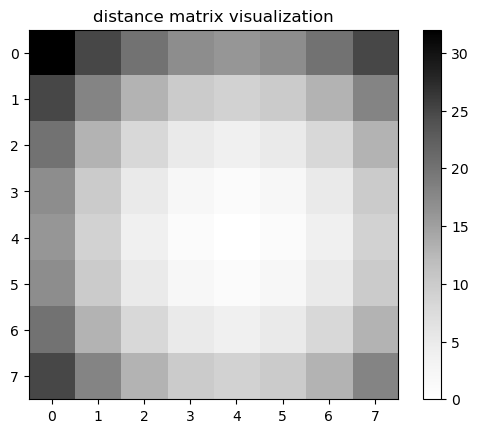

In [7]:
ref = t.zeros(1,8,8, device=device)
ref[:,4,4] += 1
dist_matrix = create_dist_matrix(ref)
fig = plt.imshow(dist_matrix.numpy(), cmap="Greys", interpolation="nearest", vmin=0, vmax=np.max(dist_matrix.numpy()))
plt.colorbar(fig)
plt.title("distance matrix visualization")
plt.show()

target_vol = 0, 8x8 grid

In [ ]:
temps1 = t.linspace(0, 1, 20)
temps2 = t.linspace(1, 25, 25)
temps = t.concat((temps1, temps2))
target_vol = 0.
ref = t.zeros(1,8,8, device=device)
ref[:,4,4] += 1
dist_matrix = create_dist_matrix(ref)

grads_v0 = []
mean_distances_v0 = []
for temp in temps:
    temp.requires_grad_()
    batch = t.zeros(200,8,8, device=device)
    batch[:,4,4] += 1
    new_temp, grad, mean_distance = step(batch, dist_matrix, temp, target_vol, eta=1, num_steps=40)
    grads_v0.append(grad.detach().cpu().numpy())
    mean_distances_v0.append(mean_distance.detach().cpu().numpy())

target_vol = 1, 8x8 grid

In [ ]:
temps1 = t.linspace(0, 1, 20)
temps2 = t.linspace(1, 25, 25)
temps = t.concat((temps1, temps2))
target_vol = 1.
ref = t.zeros(1,8,8, device=device)
ref[:,4,4] += 1
dist_matrix = create_dist_matrix(ref)

grads_v1 = []
mean_distances_v1 = []
for temp in temps:
    temp.requires_grad_()
    batch = t.zeros(200,8,8, device=device)
    batch[:,4,4] += 1
    new_temp, grad, mean_distance = step(batch, dist_matrix, temp, target_vol, eta=1, num_steps=40)
    grads_v1.append(grad.detach().cpu().numpy())
    mean_distances_v1.append(mean_distance.detach().cpu().numpy())

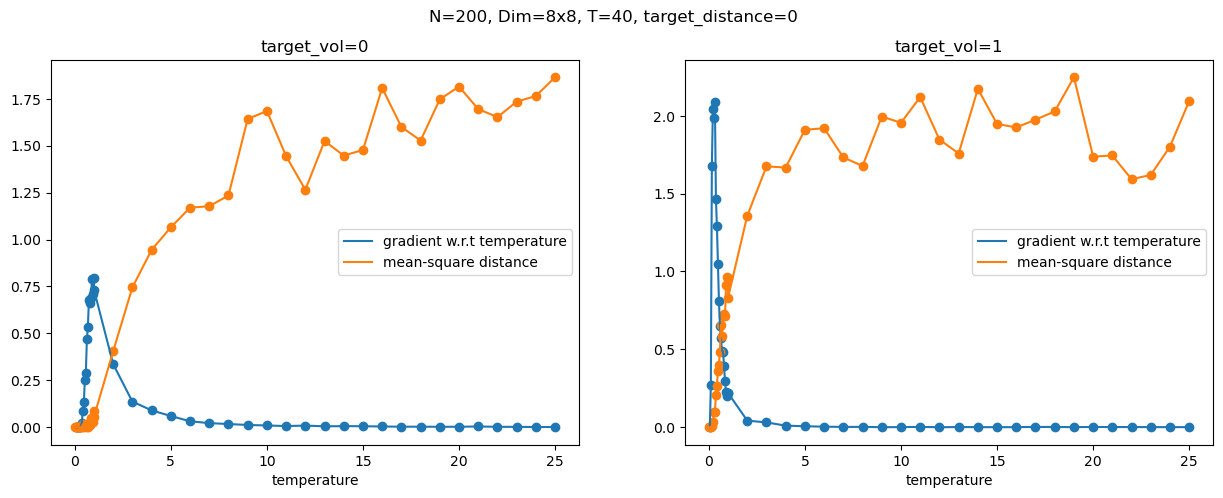

In [11]:
fig, axs = plt.subplots(1,2, figsize=(15,5))
axs[0].scatter(temps.cpu(), grads_v0)
axs[0].plot(temps.cpu(), grads_v0, label="gradient w.r.t temperature")
axs[0].scatter(temps.cpu(), mean_distances_v0)
axs[0].plot(temps.cpu(), mean_distances_v0, label="mean-square distance")
axs[0].set(title="target_vol=0", xlabel="temperature")
axs[0].legend()

axs[1].scatter(temps.cpu(), grads_v1)
axs[1].plot(temps.cpu(), grads_v1, label="gradient w.r.t temperature")
axs[1].scatter(temps.cpu(), mean_distances_v1)
axs[1].plot(temps.cpu(), mean_distances_v1, label="mean-square distance")
axs[1].set(title="target_vol=1", xlabel="temperature")
axs[1].legend()

fig.suptitle("N=200, Dim=8x8, T=40, target_distance=0")
plt.show()


# Introduce Squared loss to target distance

In [8]:
def step(batch:t.Tensor, dist_matrix:t.Tensor, temperature:t.Tensor, target_vol:float, eta:float, num_steps:int, target_distance:float):
    for i in tqdm(range(num_steps)):
        batch = MCS(batch, target_vol, temperature)
        if t.any(t.sum(batch, dim=(-1,-2)) == 0) or t.any(t.sum(batch, dim=(-1,-2)) > 2):
            print("ISSUE DETECTED, STOP SIM")
            return None, None
    # calc the distance after 100 steps    
    distances = t.sum(batch * dist_matrix, dim=(-1,-2)) / t.sum(batch, dim=(-1,-2))
    mean_distance = t.mean(distances)
    print(f"temperature: {temperature}, mean distance: {mean_distance}")
    loss = (mean_distance - target_distance)**2
    grad = t.autograd.grad(loss, temperature)[0]
    print(f"gradient: {grad}")
    return t.clamp(temperature - (eta * grad), min=1e-5, max=40.), grad, mean_distance, loss

## Num_steps = 40, 8x8 grid

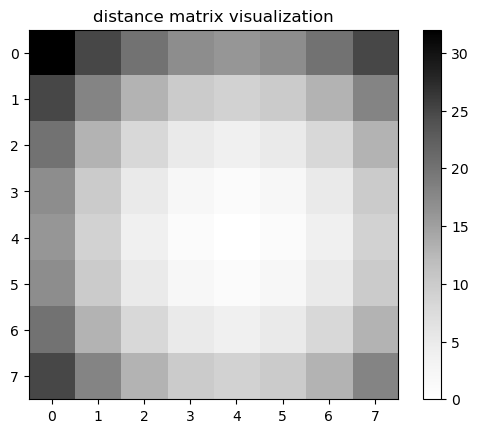

In [13]:
ref = t.zeros(1,8,8, device=device)
ref[:,4,4] += 1
dist_matrix = create_dist_matrix(ref)
fig = plt.imshow(dist_matrix.numpy(), cmap="Greys", interpolation="nearest", vmin=0, vmax=np.max(dist_matrix.numpy()))
plt.colorbar(fig)
plt.title("distance matrix visualization")
plt.show()

target_vol = 0, target_dist = 0

In [ ]:
temps1 = t.linspace(0, 1, 20)
temps2 = t.linspace(1, 25, 25)
temps = t.concat((temps1, temps2))
target_vol = 0.
ref = t.zeros(1,8,8, device=device)
ref[:,4,4] += 1
dist_matrix = create_dist_matrix(ref)
target_distance = 0.

grads_v0 = []
mean_distances_v0 = []
losses_v0 = []
for temp in temps:
    temp.requires_grad_()
    batch = t.zeros(200,8,8, device=device)
    batch[:,4,4] += 1
    new_temp, grad, mean_distance, loss = step(batch, dist_matrix, temp, target_vol, eta=1, num_steps=40, target_distance=target_distance)
    grads_v0.append(grad.detach().cpu().numpy())
    mean_distances_v0.append(mean_distance.detach().cpu().numpy())
    losses_v0.append(loss.detach().cpu().numpy())

target_vol = 1, target_dist = 0

In [ ]:
temps1 = t.linspace(0, 1, 20)
temps2 = t.linspace(1, 25, 25)
temps = t.concat((temps1, temps2))
target_vol = 1.
ref = t.zeros(1,8,8, device=device)
ref[:,4,4] += 1
dist_matrix = create_dist_matrix(ref)
target_distance = 0.

grads_v1 = []
mean_distances_v1 = []
losses_v1 = []
for temp in temps:
    temp.requires_grad_()
    batch = t.zeros(200,8,8, device=device)
    batch[:,4,4] += 1
    new_temp, grad, mean_distance, loss = step(batch, dist_matrix, temp, target_vol, eta=1, num_steps=40, target_distance=target_distance)
    grads_v1.append(grad.detach().cpu().numpy())
    mean_distances_v1.append(mean_distance.detach().cpu().numpy())
    losses_v1.append(loss.detach().cpu().numpy())

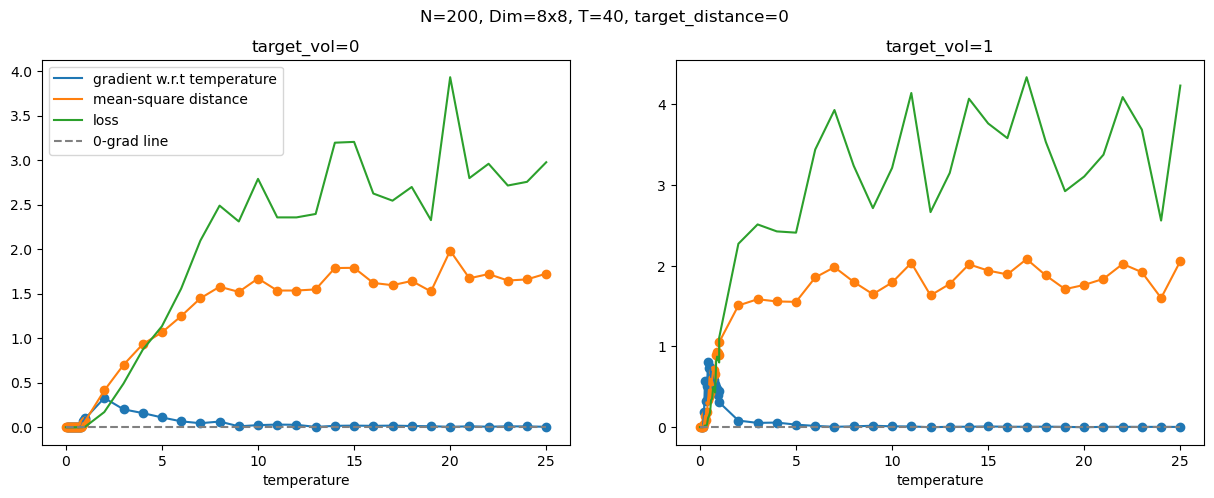

In [17]:
fig, axs = plt.subplots(1,2, figsize=(15,5))
axs[0].scatter(temps.cpu(), grads_v0)
axs[0].plot(temps.cpu(), grads_v0, label="gradient w.r.t temperature")
axs[0].scatter(temps.cpu(), mean_distances_v0)
axs[0].plot(temps.cpu(), mean_distances_v0, label="mean-square distance")
axs[0].plot(temps.cpu(), losses_v0, label="loss")
axs[0].set(title="target_vol=0", xlabel="temperature")
axs[0].hlines([0.], xmin=0, xmax=25, label="0-grad line", colors=["gray"], linestyles="dashed")
axs[0].legend()

axs[1].scatter(temps.cpu(), grads_v1)
axs[1].plot(temps.cpu(), grads_v1, label="gradient w.r.t temperature")
axs[1].scatter(temps.cpu(), mean_distances_v1)
axs[1].plot(temps.cpu(), mean_distances_v1, label="mean-square distance")
axs[1].plot(temps.cpu(), losses_v1, label="loss")
axs[1].hlines([0.], xmin=0, xmax=25, label="0-grad line", colors=["gray"], linestyles="dashed")
axs[1].set(title="target_vol=1", xlabel="temperature")

fig.suptitle("N=200, Dim=8x8, T=40, target_distance=0")
plt.show()


target_vol = 0, target_dist = 0.2

In [9]:
temps1 = t.linspace(0, 1, 20)
temps2 = t.linspace(1, 25, 25)
temps = t.concat((temps1, temps2))
target_vol = 0.
ref = t.zeros(1,8,8, device=device)
ref[:,4,4] += 1
dist_matrix = create_dist_matrix(ref)
target_distance = 0.2

grads_v0 = []
mean_distances_v0 = []
losses_v0 = []
for temp in temps:
    temp.requires_grad_()
    batch = t.zeros(200,8,8, device=device)
    batch[:,4,4] += 1
    new_temp, grad, mean_distance, loss = step(batch, dist_matrix, temp, target_vol, eta=1, num_steps=40, target_distance=target_distance)
    grads_v0.append(grad.detach().cpu().numpy())
    mean_distances_v0.append(mean_distance.detach().cpu().numpy())
    losses_v0.append(loss.detach().cpu().numpy())

100%|██████████| 40/40 [00:01<00:00, 36.13it/s]


temperature: 0.0, mean distance: 0.0
gradient: nan


100%|██████████| 40/40 [00:01<00:00, 36.19it/s]


temperature: 0.05263157933950424, mean distance: 0.0
gradient: -3.1905611478606256e-29


100%|██████████| 40/40 [00:01<00:00, 35.36it/s]


temperature: 0.10526315867900848, mean distance: 0.0
gradient: -3.838000880648784e-13


100%|██████████| 40/40 [00:01<00:00, 38.16it/s]


temperature: 0.15789473056793213, mean distance: 0.0
gradient: -1.9943618312368017e-08


100%|██████████| 40/40 [00:01<00:00, 35.61it/s]


temperature: 0.21052631735801697, mean distance: 0.0
gradient: -9.141811460722238e-06


100%|██████████| 40/40 [00:01<00:00, 36.62it/s]


temperature: 0.2631579041481018, mean distance: 0.0
gradient: -0.001079941401258111


100%|██████████| 40/40 [00:01<00:00, 38.56it/s]


temperature: 0.31578946113586426, mean distance: 0.0
gradient: -0.004401925951242447


100%|██████████| 40/40 [00:01<00:00, 39.09it/s]


temperature: 0.3684210479259491, mean distance: 0.0
gradient: -0.010136814787983894


100%|██████████| 40/40 [00:01<00:00, 35.39it/s]


temperature: 0.42105263471603394, mean distance: 0.0
gradient: -0.02806832455098629


100%|██████████| 40/40 [00:01<00:00, 35.74it/s]


temperature: 0.4736842215061188, mean distance: 0.0
gradient: -0.05791828781366348


100%|██████████| 40/40 [00:01<00:00, 36.76it/s]


temperature: 0.5263158082962036, mean distance: 0.0
gradient: -0.12933748960494995


100%|██████████| 40/40 [00:01<00:00, 37.37it/s]


temperature: 0.5789473652839661, mean distance: 0.0
gradient: -0.14162443578243256


100%|██████████| 40/40 [00:01<00:00, 38.34it/s]


temperature: 0.6315789222717285, mean distance: 0.010000000000000002
gradient: -0.16472050547599792


100%|██████████| 40/40 [00:01<00:00, 37.69it/s]


temperature: 0.6842105388641357, mean distance: 0.005000000000000001
gradient: -0.22175458073616028


100%|██████████| 40/40 [00:01<00:00, 36.57it/s]


temperature: 0.7368420958518982, mean distance: 0.0075000000000000015
gradient: -0.23194438219070435


100%|██████████| 40/40 [00:01<00:00, 37.98it/s]


temperature: 0.7894736528396606, mean distance: 0.035
gradient: -0.1971255987882614


100%|██████████| 40/40 [00:01<00:00, 38.23it/s]


temperature: 0.8421052694320679, mean distance: 0.0175
gradient: -0.2363356351852417


100%|██████████| 40/40 [00:01<00:00, 38.31it/s]


temperature: 0.8947368264198303, mean distance: 0.0325
gradient: -0.23780880868434906


100%|██████████| 40/40 [00:01<00:00, 37.55it/s]


temperature: 0.9473684430122375, mean distance: 0.0575
gradient: -0.19932793080806732


100%|██████████| 40/40 [00:01<00:00, 38.31it/s]


temperature: 1.0, mean distance: 0.07250000000000001
gradient: -0.19506564736366272


100%|██████████| 40/40 [00:01<00:00, 38.53it/s]


temperature: 1.0, mean distance: 0.12500000000000003
gradient: -0.1065320074558258


100%|██████████| 40/40 [00:01<00:00, 37.48it/s]


temperature: 2.0, mean distance: 0.35
gradient: 0.10812418907880783


100%|██████████| 40/40 [00:01<00:00, 36.62it/s]


temperature: 3.0, mean distance: 0.685
gradient: 0.15418899059295654


100%|██████████| 40/40 [00:01<00:00, 35.23it/s]


temperature: 4.0, mean distance: 0.915
gradient: 0.11015556007623672


100%|██████████| 40/40 [00:01<00:00, 36.89it/s]


temperature: 5.0, mean distance: 1.085
gradient: 0.0982845276594162


100%|██████████| 40/40 [00:01<00:00, 35.48it/s]


temperature: 6.0, mean distance: 1.225
gradient: 0.051939163357019424


100%|██████████| 40/40 [00:01<00:00, 36.32it/s]


temperature: 7.0, mean distance: 1.3225
gradient: 0.05790325999259949


100%|██████████| 40/40 [00:01<00:00, 36.03it/s]


temperature: 8.0, mean distance: 1.455
gradient: 0.042686913162469864


100%|██████████| 40/40 [00:01<00:00, 35.67it/s]


temperature: 9.0, mean distance: 1.3975
gradient: 0.032501667737960815


100%|██████████| 40/40 [00:01<00:00, 35.30it/s]


temperature: 10.0, mean distance: 1.4425
gradient: 0.024401120841503143


100%|██████████| 40/40 [00:01<00:00, 35.80it/s]


temperature: 11.0, mean distance: 1.46
gradient: 0.024052202701568604


100%|██████████| 40/40 [00:01<00:00, 35.61it/s]


temperature: 12.0, mean distance: 1.7075
gradient: 0.019990073516964912


100%|██████████| 40/40 [00:01<00:00, 35.52it/s]


temperature: 13.0, mean distance: 1.9125000000000003
gradient: 0.003581508295610547


100%|██████████| 40/40 [00:01<00:00, 35.20it/s]


temperature: 14.0, mean distance: 1.8075
gradient: 0.0063001071102917194


100%|██████████| 40/40 [00:01<00:00, 35.87it/s]


temperature: 15.0, mean distance: 1.585
gradient: 0.016210582107305527


100%|██████████| 40/40 [00:01<00:00, 35.08it/s]


temperature: 16.0, mean distance: 1.645
gradient: 0.00882120430469513


100%|██████████| 40/40 [00:01<00:00, 35.02it/s]


temperature: 17.0, mean distance: 1.555
gradient: 0.008085080422461033


100%|██████████| 40/40 [00:01<00:00, 35.02it/s]


temperature: 18.0, mean distance: 1.355
gradient: 0.007543782703578472


100%|██████████| 40/40 [00:01<00:00, 35.05it/s]


temperature: 19.0, mean distance: 1.5575
gradient: 0.008866585791110992


100%|██████████| 40/40 [00:01<00:00, 34.62it/s]


temperature: 20.0, mean distance: 1.5125
gradient: 0.007711134850978851


100%|██████████| 40/40 [00:01<00:00, 34.93it/s]


temperature: 21.0, mean distance: 1.4725
gradient: 0.008518412709236145


100%|██████████| 40/40 [00:01<00:00, 35.17it/s]


temperature: 22.0, mean distance: 1.8725
gradient: 0.0065348269417881966


100%|██████████| 40/40 [00:01<00:00, 34.09it/s]


temperature: 23.0, mean distance: 1.675
gradient: 0.006236390210688114


100%|██████████| 40/40 [00:01<00:00, 35.08it/s]


temperature: 24.0, mean distance: 1.8825
gradient: 0.004536099266260862


100%|██████████| 40/40 [00:01<00:00, 35.23it/s]

temperature: 25.0, mean distance: 1.775
gradient: 0.0032821735367178917


target_vol = 1, target_dist = 0.2

In [10]:
temps1 = t.linspace(0, 1, 20)
temps2 = t.linspace(1, 25, 25)
temps = t.concat((temps1, temps2))
target_vol = 1.
ref = t.zeros(1,8,8, device=device)
ref[:,4,4] += 1
dist_matrix = create_dist_matrix(ref)
target_distance = 0.2

grads_v1 = []
mean_distances_v1 = []
losses_v1 = []
for temp in temps:
    temp.requires_grad_()
    batch = t.zeros(200,8,8, device=device)
    batch[:,4,4] += 1
    new_temp, grad, mean_distance, loss = step(batch, dist_matrix, temp, target_vol, eta=1, num_steps=40, target_distance=target_distance)
    grads_v1.append(grad.detach().cpu().numpy())
    mean_distances_v1.append(mean_distance.detach().cpu().numpy())
    losses_v1.append(loss.detach().cpu().numpy())

100%|██████████| 40/40 [00:01<00:00, 29.41it/s]


temperature: 0.0, mean distance: 0.0
gradient: nan


100%|██████████| 40/40 [00:01<00:00, 28.28it/s]


temperature: 0.05263157933950424, mean distance: 0.0
gradient: -0.00036649443791247904


100%|██████████| 40/40 [00:01<00:00, 29.54it/s]


temperature: 0.10526315867900848, mean distance: 0.0
gradient: -0.0772474929690361


100%|██████████| 40/40 [00:01<00:00, 30.30it/s]


temperature: 0.15789473056793213, mean distance: 0.005
gradient: -0.6385544538497925


100%|██████████| 40/40 [00:01<00:00, 29.17it/s]


temperature: 0.21052631735801697, mean distance: 0.005000000000000001
gradient: -0.8323855996131897


100%|██████████| 40/40 [00:01<00:00, 28.98it/s]


temperature: 0.2631579041481018, mean distance: 0.065
gradient: -0.6051746606826782


100%|██████████| 40/40 [00:01<00:00, 31.10it/s]


temperature: 0.31578946113586426, mean distance: 0.0825
gradient: -0.4563475251197815


100%|██████████| 40/40 [00:01<00:00, 37.94it/s]


temperature: 0.3684210479259491, mean distance: 0.18
gradient: -0.059062711894512177


100%|██████████| 40/40 [00:01<00:00, 38.45it/s]


temperature: 0.42105263471603394, mean distance: 0.30000000000000004
gradient: 0.23248741030693054


100%|██████████| 40/40 [00:01<00:00, 37.83it/s]


temperature: 0.4736842215061188, mean distance: 0.415
gradient: 0.3888840973377228


100%|██████████| 40/40 [00:01<00:00, 38.34it/s]


temperature: 0.5263158082962036, mean distance: 0.485
gradient: 0.49295172095298767


100%|██████████| 40/40 [00:01<00:00, 37.06it/s]


temperature: 0.5789473652839661, mean distance: 0.4425
gradient: 0.35769933462142944


100%|██████████| 40/40 [00:01<00:00, 35.96it/s]


temperature: 0.6315789222717285, mean distance: 0.5775
gradient: 0.4746834337711334


100%|██████████| 40/40 [00:01<00:00, 37.37it/s]


temperature: 0.6842105388641357, mean distance: 0.495
gradient: 0.3167212903499603


100%|██████████| 40/40 [00:01<00:00, 37.17it/s]


temperature: 0.7368420958518982, mean distance: 0.71
gradient: 0.45428043603897095


100%|██████████| 40/40 [00:01<00:00, 36.96it/s]


temperature: 0.7894736528396606, mean distance: 0.7675
gradient: 0.335229754447937


100%|██████████| 40/40 [00:01<00:00, 36.32it/s]


temperature: 0.8421052694320679, mean distance: 0.81
gradient: 0.3417551815509796


100%|██████████| 40/40 [00:01<00:00, 36.09it/s]


temperature: 0.8947368264198303, mean distance: 0.9875
gradient: 0.354850172996521


100%|██████████| 40/40 [00:01<00:00, 36.39it/s]


temperature: 0.9473684430122375, mean distance: 1.04
gradient: 0.4363638460636139


100%|██████████| 40/40 [00:01<00:00, 36.06it/s]


temperature: 1.0, mean distance: 1.04
gradient: 0.38579967617988586


100%|██████████| 40/40 [00:01<00:00, 36.79it/s]


temperature: 1.0, mean distance: 1.0775
gradient: 0.3929823637008667


100%|██████████| 40/40 [00:01<00:00, 35.83it/s]


temperature: 2.0, mean distance: 1.27
gradient: 0.1474095731973648


100%|██████████| 40/40 [00:01<00:00, 34.27it/s]


temperature: 3.0, mean distance: 1.365
gradient: 0.027944553643465042


100%|██████████| 40/40 [00:01<00:00, 35.52it/s]


temperature: 4.0, mean distance: 1.645
gradient: 0.03394988551735878


100%|██████████| 40/40 [00:01<00:00, 34.74it/s]


temperature: 5.0, mean distance: 1.5925
gradient: 0.01986171491444111


100%|██████████| 40/40 [00:01<00:00, 34.99it/s]


temperature: 6.0, mean distance: 1.615
gradient: 0.014981280080974102


100%|██████████| 40/40 [00:01<00:00, 35.14it/s]


temperature: 7.0, mean distance: 2.035
gradient: 0.007285626605153084


100%|██████████| 40/40 [00:01<00:00, 33.80it/s]


temperature: 8.0, mean distance: 1.805
gradient: 0.00790505949407816


100%|██████████| 40/40 [00:01<00:00, 34.74it/s]


temperature: 9.0, mean distance: 1.8725
gradient: 0.007146577350795269


100%|██████████| 40/40 [00:01<00:00, 34.15it/s]


temperature: 10.0, mean distance: 1.9225
gradient: 0.007519882172346115


100%|██████████| 40/40 [00:01<00:00, 34.45it/s]


temperature: 11.0, mean distance: 1.785
gradient: 0.00898166373372078


100%|██████████| 40/40 [00:01<00:00, 34.33it/s]


temperature: 12.0, mean distance: 1.8075
gradient: 0.004577769432216883


100%|██████████| 40/40 [00:01<00:00, 35.71it/s]


temperature: 13.0, mean distance: 1.96
gradient: -0.00039028702303767204


100%|██████████| 40/40 [00:01<00:00, 34.47it/s]


temperature: 14.0, mean distance: 1.455
gradient: 0.004687939770519733


100%|██████████| 40/40 [00:01<00:00, 34.62it/s]


temperature: 15.0, mean distance: 2.07
gradient: 0.006626634858548641


100%|██████████| 40/40 [00:01<00:00, 34.42it/s]


temperature: 16.0, mean distance: 2.005
gradient: 0.00016158206562977284


100%|██████████| 40/40 [00:01<00:00, 34.39it/s]


temperature: 17.0, mean distance: 1.8425
gradient: 0.0028609302826225758


100%|██████████| 40/40 [00:01<00:00, 32.41it/s]


temperature: 18.0, mean distance: 1.815
gradient: 0.001775428419932723


100%|██████████| 40/40 [00:01<00:00, 33.86it/s]


temperature: 19.0, mean distance: 1.6575
gradient: 0.0032148470636457205


100%|██████████| 40/40 [00:01<00:00, 34.80it/s]


temperature: 20.0, mean distance: 1.755
gradient: 0.0019261788111180067


100%|██████████| 40/40 [00:01<00:00, 34.80it/s]


temperature: 21.0, mean distance: 2.0475
gradient: 0.002388477325439453


100%|██████████| 40/40 [00:01<00:00, 34.93it/s]


temperature: 22.0, mean distance: 1.715
gradient: 0.004207214340567589


100%|██████████| 40/40 [00:01<00:00, 34.40it/s]


temperature: 23.0, mean distance: 1.89
gradient: 0.0015800383407622576


100%|██████████| 40/40 [00:01<00:00, 35.08it/s]


temperature: 24.0, mean distance: 1.97
gradient: 0.0008043891284614801


100%|██████████| 40/40 [00:01<00:00, 32.86it/s]

temperature: 25.0, mean distance: 1.8375
gradient: 0.0033010896295309067


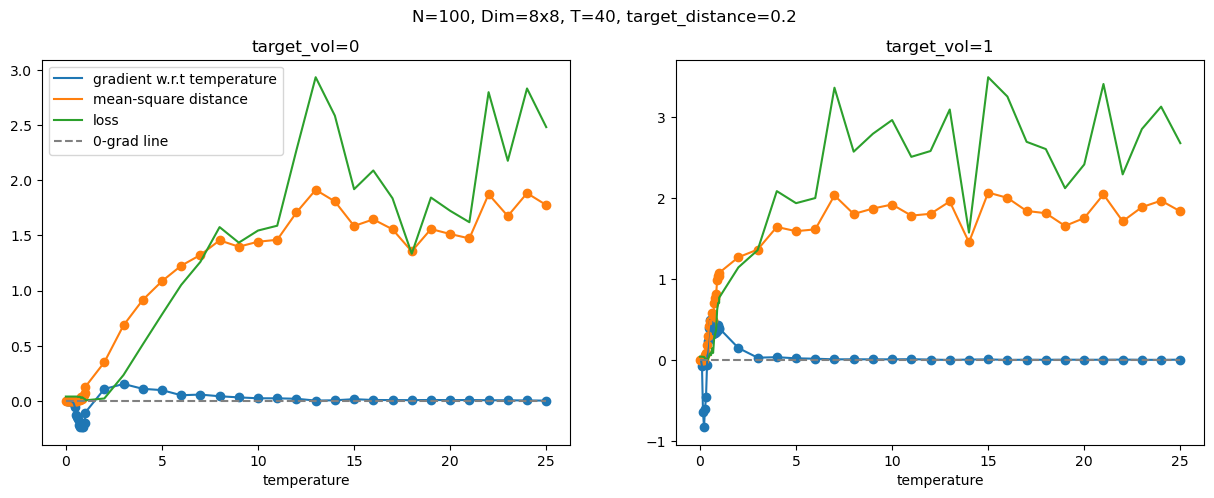

In [11]:
fig, axs = plt.subplots(1,2, figsize=(15,5))
axs[0].scatter(temps.cpu(), grads_v0)
axs[0].plot(temps.cpu(), grads_v0, label="gradient w.r.t temperature")
axs[0].scatter(temps.cpu(), mean_distances_v0)
axs[0].plot(temps.cpu(), mean_distances_v0, label="mean-square distance")
axs[0].plot(temps.cpu(), losses_v0, label="loss")
axs[0].set(title="target_vol=0", xlabel="temperature")
axs[0].hlines([0.], xmin=0, xmax=25, label="0-grad line", colors=["gray"], linestyles="dashed")
axs[0].legend()

axs[1].scatter(temps.cpu(), grads_v1)
axs[1].plot(temps.cpu(), grads_v1, label="gradient w.r.t temperature")
axs[1].scatter(temps.cpu(), mean_distances_v1)
axs[1].plot(temps.cpu(), mean_distances_v1, label="mean-square distance")
axs[1].plot(temps.cpu(), losses_v1, label="loss")
axs[1].hlines([0.], xmin=0, xmax=25, label="0-grad line", colors=["gray"], linestyles="dashed")
axs[1].set(title="target_vol=1", xlabel="temperature")

fig.suptitle("N=100, Dim=8x8, T=40, target_distance=0.2")
plt.show()


target_vol = 0, target_dist = 1.2

In [12]:
temps1 = t.linspace(0, 1, 20)
temps2 = t.linspace(1, 25, 25)
temps = t.concat((temps1, temps2))
target_vol = 0.
ref = t.zeros(1,8,8, device=device)
ref[:,4,4] += 1
dist_matrix = create_dist_matrix(ref)
target_distance = 1.2

grads_v0 = []
mean_distances_v0 = []
losses_v0 = []
for temp in temps:
    temp.requires_grad_()
    batch = t.zeros(100,8,8, device=device)
    batch[:,4,4] += 1
    new_temp, grad, mean_distance, loss = step(batch, dist_matrix, temp, target_vol, eta=1, num_steps=40, target_distance=target_distance)
    grads_v0.append(grad.detach().cpu().numpy())
    mean_distances_v0.append(mean_distance.detach().cpu().numpy())
    losses_v0.append(loss.detach().cpu().numpy())

100%|██████████| 40/40 [00:00<00:00, 55.24it/s]


temperature: 0.0, mean distance: 0.0
gradient: nan


100%|██████████| 40/40 [00:00<00:00, 60.14it/s]


temperature: 0.05263157933950424, mean distance: 0.0
gradient: -1.1498680473528925e-28


100%|██████████| 40/40 [00:00<00:00, 59.51it/s]


temperature: 0.10526315867900848, mean distance: 0.0
gradient: -1.9088268292388744e-12


100%|██████████| 40/40 [00:00<00:00, 60.68it/s]


temperature: 0.15789473056793213, mean distance: 0.0
gradient: -1.1476457473236223e-07


100%|██████████| 40/40 [00:00<00:00, 57.62it/s]


temperature: 0.21052631735801697, mean distance: 0.0
gradient: -5.1006125431740656e-05


100%|██████████| 40/40 [00:00<00:00, 60.05it/s]


temperature: 0.2631579041481018, mean distance: 0.0
gradient: -0.003276892937719822


100%|██████████| 40/40 [00:00<00:00, 60.14it/s]


temperature: 0.31578946113586426, mean distance: 0.0
gradient: -0.015724340453743935


100%|██████████| 40/40 [00:00<00:00, 58.13it/s]


temperature: 0.3684210479259491, mean distance: 0.0
gradient: -0.04531281441450119


100%|██████████| 40/40 [00:00<00:00, 59.16it/s]


temperature: 0.42105263471603394, mean distance: 0.0
gradient: -0.18963663280010223


100%|██████████| 40/40 [00:00<00:00, 60.59it/s]


temperature: 0.4736842215061188, mean distance: 0.0
gradient: -0.49927231669425964


100%|██████████| 40/40 [00:00<00:00, 60.50it/s]


temperature: 0.5263158082962036, mean distance: 0.0
gradient: -0.4199203550815582


100%|██████████| 40/40 [00:00<00:00, 59.33it/s]


temperature: 0.5789473652839661, mean distance: 0.0
gradient: -0.6968425512313843


100%|██████████| 40/40 [00:00<00:00, 61.43it/s]


temperature: 0.6315789222717285, mean distance: 0.005
gradient: -1.0663965940475464


100%|██████████| 40/40 [00:00<00:00, 61.43it/s]


temperature: 0.6842105388641357, mean distance: 0.0
gradient: -1.3816431760787964


100%|██████████| 40/40 [00:00<00:00, 70.66it/s]


temperature: 0.7368420958518982, mean distance: 0.015
gradient: -1.7190492153167725


100%|██████████| 40/40 [00:00<00:00, 76.46it/s]


temperature: 0.7894736528396606, mean distance: 0.02
gradient: -1.463188648223877


100%|██████████| 40/40 [00:00<00:00, 73.24it/s]


temperature: 0.8421052694320679, mean distance: 0.03000000000000001
gradient: -1.6651972532272339


100%|██████████| 40/40 [00:00<00:00, 63.78it/s]


temperature: 0.8947368264198303, mean distance: 0.030000000000000006
gradient: -1.7187055349349976


100%|██████████| 40/40 [00:00<00:00, 61.34it/s]


temperature: 0.9473684430122375, mean distance: 0.04000000000000001
gradient: -1.5142090320587158


100%|██████████| 40/40 [00:00<00:00, 72.06it/s]


temperature: 1.0, mean distance: 0.05
gradient: -1.7485994100570679


100%|██████████| 40/40 [00:00<00:00, 75.33it/s]


temperature: 1.0, mean distance: 0.030000000000000006
gradient: -1.877031922340393


100%|██████████| 40/40 [00:00<00:00, 75.74it/s]


temperature: 2.0, mean distance: 0.30000000000000004
gradient: -0.7355188727378845


100%|██████████| 40/40 [00:00<00:00, 74.89it/s]


temperature: 3.0, mean distance: 0.795
gradient: -0.10895693302154541


100%|██████████| 40/40 [00:00<00:00, 69.67it/s]


temperature: 4.0, mean distance: 0.73
gradient: -0.08090321719646454


100%|██████████| 40/40 [00:00<00:00, 71.67it/s]


temperature: 5.0, mean distance: 1.2600000000000002
gradient: 0.0048004197888076305


100%|██████████| 40/40 [00:00<00:00, 70.65it/s]


temperature: 6.0, mean distance: 1.18
gradient: -0.0011269787792116404


100%|██████████| 40/40 [00:00<00:00, 68.71it/s]


temperature: 7.0, mean distance: 1.195
gradient: -0.00029332979465834796


100%|██████████| 40/40 [00:00<00:00, 65.45it/s]


temperature: 8.0, mean distance: 1.59
gradient: 0.012970506213605404


100%|██████████| 40/40 [00:00<00:00, 69.43it/s]


temperature: 9.0, mean distance: 1.705
gradient: 0.012821809388697147


100%|██████████| 40/40 [00:00<00:00, 69.55it/s]


temperature: 10.0, mean distance: 1.665
gradient: 0.007382240612059832


100%|██████████| 40/40 [00:00<00:00, 72.58it/s]


temperature: 11.0, mean distance: 1.455
gradient: 0.004030189476907253


100%|██████████| 40/40 [00:00<00:00, 68.48it/s]


temperature: 12.0, mean distance: 1.505
gradient: 0.003093506908044219


100%|██████████| 40/40 [00:00<00:00, 71.67it/s]


temperature: 13.0, mean distance: 1.68
gradient: 0.006678207777440548


100%|██████████| 40/40 [00:00<00:00, 67.10it/s]


temperature: 14.0, mean distance: 1.73
gradient: 0.0007506098481826484


100%|██████████| 40/40 [00:00<00:00, 70.41it/s]


temperature: 15.0, mean distance: 1.31
gradient: 0.0011279538739472628


100%|██████████| 40/40 [00:00<00:00, 70.41it/s]


temperature: 16.0, mean distance: 1.665
gradient: 0.0047536506317555904


100%|██████████| 40/40 [00:00<00:00, 69.79it/s]


temperature: 17.0, mean distance: 1.65
gradient: 0.0030345269478857517


100%|██████████| 40/40 [00:00<00:00, 71.03it/s]


temperature: 18.0, mean distance: 1.505
gradient: 0.002287656767293811


100%|██████████| 40/40 [00:00<00:00, 69.55it/s]


temperature: 19.0, mean distance: 1.685
gradient: 0.001070322934538126


100%|██████████| 40/40 [00:00<00:00, 69.19it/s]


temperature: 20.0, mean distance: 1.46
gradient: 0.000757953617721796


100%|██████████| 40/40 [00:00<00:00, 69.91it/s]


temperature: 21.0, mean distance: 2.32
gradient: 0.0040113190189003944


100%|██████████| 40/40 [00:00<00:00, 67.90it/s]


temperature: 22.0, mean distance: 1.8
gradient: 0.0018476848490536213


100%|██████████| 40/40 [00:00<00:00, 68.24it/s]


temperature: 23.0, mean distance: 1.675
gradient: 0.00013865478103980422


100%|██████████| 40/40 [00:00<00:00, 68.60it/s]


temperature: 24.0, mean distance: 1.395
gradient: 0.0007868860848248005


100%|██████████| 40/40 [00:00<00:00, 69.43it/s]

temperature: 25.0, mean distance: 1.77
gradient: 0.00021032373479101807


target_vol = 1, target_distance = 1.2

In [13]:
temps1 = t.linspace(0, 1, 20)
temps2 = t.linspace(1, 25, 25)
temps = t.concat((temps1, temps2))
target_vol = 1.
ref = t.zeros(1,8,8, device=device)
ref[:,4,4] += 1
dist_matrix = create_dist_matrix(ref)
target_distance = 1.2

grads_v1 = []
mean_distances_v1 = []
losses_v1 = []
for temp in temps:
    temp.requires_grad_()
    batch = t.zeros(100,8,8, device=device)
    batch[:,4,4] += 1
    new_temp, grad, mean_distance, loss = step(batch, dist_matrix, temp, target_vol, eta=1, num_steps=40, target_distance=target_distance)
    grads_v1.append(grad.detach().cpu().numpy())
    mean_distances_v1.append(mean_distance.detach().cpu().numpy())
    losses_v1.append(loss.detach().cpu().numpy())

100%|██████████| 40/40 [00:00<00:00, 54.41it/s]


temperature: 0.0, mean distance: 0.0
gradient: nan


100%|██████████| 40/40 [00:00<00:00, 61.71it/s]


temperature: 0.05263157933950424, mean distance: 0.0
gradient: -0.00028944844962097704


100%|██████████| 40/40 [00:00<00:00, 56.09it/s]


temperature: 0.10526315867900848, mean distance: 0.0
gradient: -0.37010085582733154


100%|██████████| 40/40 [00:00<00:00, 59.69it/s]


temperature: 0.15789473056793213, mean distance: 0.0
gradient: -3.6017792224884033


100%|██████████| 40/40 [00:00<00:00, 61.71it/s]


temperature: 0.21052631735801697, mean distance: 0.025
gradient: -5.469153881072998


100%|██████████| 40/40 [00:00<00:00, 61.05it/s]


temperature: 0.2631579041481018, mean distance: 0.08
gradient: -5.814583778381348


100%|██████████| 40/40 [00:00<00:00, 59.69it/s]


temperature: 0.31578946113586426, mean distance: 0.18500000000000003
gradient: -3.6034634113311768


100%|██████████| 40/40 [00:00<00:00, 59.96it/s]


temperature: 0.3684210479259491, mean distance: 0.22
gradient: -2.8936057090759277


100%|██████████| 40/40 [00:00<00:00, 58.47it/s]


temperature: 0.42105263471603394, mean distance: 0.3350000000000001
gradient: -2.137411594390869


100%|██████████| 40/40 [00:00<00:00, 58.81it/s]


temperature: 0.4736842215061188, mean distance: 0.405
gradient: -1.7804372310638428


100%|██████████| 40/40 [00:00<00:00, 58.72it/s]


temperature: 0.5263158082962036, mean distance: 0.47
gradient: -1.4327385425567627


100%|██████████| 40/40 [00:00<00:00, 56.25it/s]


temperature: 0.5789473652839661, mean distance: 0.68
gradient: -0.6562100052833557


100%|██████████| 40/40 [00:00<00:00, 59.78it/s]


temperature: 0.6315789222717285, mean distance: 0.7750000000000001
gradient: -0.43887802958488464


100%|██████████| 40/40 [00:00<00:00, 70.16it/s]


temperature: 0.6842105388641357, mean distance: 0.755
gradient: -0.316908061504364


100%|██████████| 40/40 [00:00<00:00, 73.11it/s]


temperature: 0.7368420958518982, mean distance: 0.6750000000000002
gradient: -0.4789140224456787


100%|██████████| 40/40 [00:00<00:00, 72.32it/s]


temperature: 0.7894736528396606, mean distance: 0.7600000000000001
gradient: -0.3458585739135742


100%|██████████| 40/40 [00:00<00:00, 72.84it/s]


temperature: 0.8421052694320679, mean distance: 0.995
gradient: -0.09862691909074783


100%|██████████| 40/40 [00:00<00:00, 72.71it/s]


temperature: 0.8947368264198303, mean distance: 0.85
gradient: -0.16417138278484344


100%|██████████| 40/40 [00:00<00:00, 70.53it/s]


temperature: 0.9473684430122375, mean distance: 0.775
gradient: -0.23936794698238373


100%|██████████| 40/40 [00:00<00:00, 68.36it/s]


temperature: 1.0, mean distance: 1.04
gradient: -0.06617593765258789


100%|██████████| 40/40 [00:00<00:00, 73.50it/s]


temperature: 1.0, mean distance: 0.9200000000000002
gradient: -0.13590800762176514


100%|██████████| 40/40 [00:00<00:00, 70.16it/s]


temperature: 2.0, mean distance: 1.32
gradient: 0.009406521916389465


100%|██████████| 40/40 [00:00<00:00, 67.55it/s]


temperature: 3.0, mean distance: 1.445
gradient: 0.00409335270524025


100%|██████████| 40/40 [00:00<00:00, 68.60it/s]


temperature: 4.0, mean distance: 1.755
gradient: 0.002016735030338168


100%|██████████| 40/40 [00:00<00:00, 67.44it/s]


temperature: 5.0, mean distance: 1.63
gradient: 0.010217353701591492


100%|██████████| 40/40 [00:00<00:00, 67.44it/s]


temperature: 6.0, mean distance: 1.61
gradient: 0.00040803130832500756


100%|██████████| 40/40 [00:00<00:00, 66.21it/s]


temperature: 7.0, mean distance: 1.595
gradient: 0.0013654750073328614


100%|██████████| 40/40 [00:00<00:00, 68.71it/s]


temperature: 8.0, mean distance: 1.82
gradient: 0.0058552916161715984


100%|██████████| 40/40 [00:00<00:00, 70.04it/s]


temperature: 9.0, mean distance: 1.715
gradient: 0.002342174295336008


100%|██████████| 40/40 [00:00<00:00, 69.07it/s]


temperature: 10.0, mean distance: 1.82
gradient: 0.0031776789110153913


100%|██████████| 40/40 [00:00<00:00, 67.10it/s]


temperature: 11.0, mean distance: 1.74
gradient: 0.003682353300973773


100%|██████████| 40/40 [00:00<00:00, 68.01it/s]


temperature: 12.0, mean distance: 1.865
gradient: 0.005820979364216328


100%|██████████| 40/40 [00:00<00:00, 68.24it/s]


temperature: 13.0, mean distance: 1.685
gradient: 0.0017297081649303436


100%|██████████| 40/40 [00:00<00:00, 68.83it/s]


temperature: 14.0, mean distance: 1.87
gradient: 0.000127163075376302


100%|██████████| 40/40 [00:00<00:00, 68.01it/s]


temperature: 15.0, mean distance: 1.815
gradient: 0.0006813143845647573


100%|██████████| 40/40 [00:00<00:00, 65.88it/s]


temperature: 16.0, mean distance: 1.655
gradient: 0.0020185320172458887


100%|██████████| 40/40 [00:00<00:00, 67.72it/s]


temperature: 17.0, mean distance: 1.625
gradient: 0.0014480827376246452


100%|██████████| 40/40 [00:00<00:00, 69.07it/s]


temperature: 18.0, mean distance: 1.6300000000000003
gradient: 0.0006647887639701366


100%|██████████| 40/40 [00:00<00:00, 67.67it/s]


temperature: 19.0, mean distance: 1.76
gradient: 0.0016885432414710522


100%|██████████| 40/40 [00:00<00:00, 69.31it/s]


temperature: 20.0, mean distance: 1.795
gradient: 0.0006590406992472708


100%|██████████| 40/40 [00:00<00:00, 66.65it/s]


temperature: 21.0, mean distance: 2.075
gradient: 0.0018707711715251207


100%|██████████| 40/40 [00:00<00:00, 69.19it/s]


temperature: 22.0, mean distance: 1.895
gradient: 0.00040631397860124707


100%|██████████| 40/40 [00:00<00:00, 66.76it/s]


temperature: 23.0, mean distance: 1.565
gradient: 0.00014711452240590006


100%|██████████| 40/40 [00:00<00:00, 70.78it/s]


temperature: 24.0, mean distance: 1.59
gradient: -8.345126116182655e-05


100%|██████████| 40/40 [00:00<00:00, 68.71it/s]

temperature: 25.0, mean distance: 1.9600000000000002
gradient: 0.000779041089117527


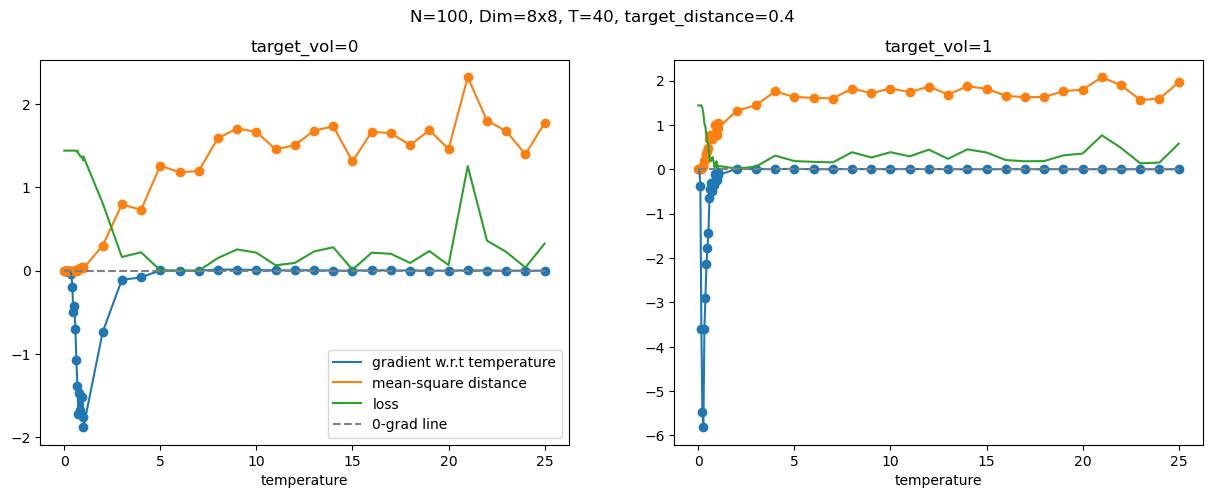

In [14]:
fig, axs = plt.subplots(1,2, figsize=(15,5))
axs[0].scatter(temps.cpu(), grads_v0)
axs[0].plot(temps.cpu(), grads_v0, label="gradient w.r.t temperature")
axs[0].scatter(temps.cpu(), mean_distances_v0)
axs[0].plot(temps.cpu(), mean_distances_v0, label="mean-square distance")
axs[0].plot(temps.cpu(), losses_v0, label="loss")
axs[0].set(title="target_vol=0", xlabel="temperature")
axs[0].hlines([0.], xmin=0, xmax=25, label="0-grad line", colors=["gray"], linestyles="dashed")
axs[0].legend()

axs[1].scatter(temps.cpu(), grads_v1)
axs[1].plot(temps.cpu(), grads_v1, label="gradient w.r.t temperature")
axs[1].scatter(temps.cpu(), mean_distances_v1)
axs[1].plot(temps.cpu(), mean_distances_v1, label="mean-square distance")
axs[1].plot(temps.cpu(), losses_v1, label="loss")
axs[1].hlines([0.], xmin=0, xmax=25, label="0-grad line", colors=["gray"], linestyles="dashed")
axs[1].set(title="target_vol=1", xlabel="temperature")

fig.suptitle("N=100, Dim=8x8, T=40, target_distance=0.4")
plt.show()


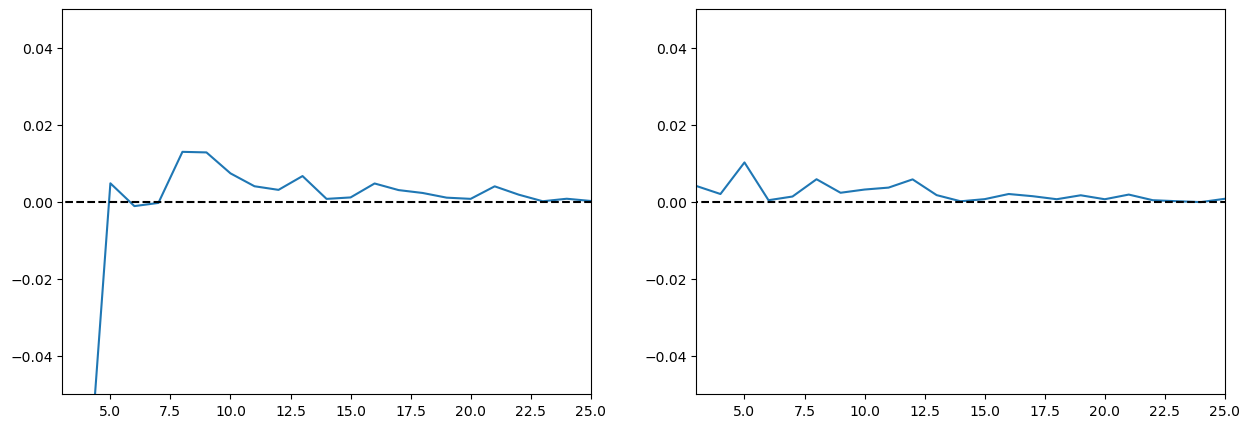

In [25]:
fig, axs = plt.subplots(1,2,figsize=(15,5))
axs[0].plot(temps.cpu(), grads_v0)
axs[0].hlines([0.], xmin=0, xmax=25, linestyles="dashed", colors=["black"])
axs[0].set(ylim=(-0.05, 0.05), xlim=(3,25))

axs[1].plot(temps.cpu(), grads_v1)
axs[1].hlines([0.], xmin=0, xmax=25, linestyles="dashed", colors=["black"])
axs[1].set(ylim=(-0.05,0.05), xlim=(3,25))

plt.show()

In [37]:
temps1 = t.linspace(0, 1, 20)
temps2 = t.linspace(1, 25, 25)
temps = t.concat((temps1, temps2))
target_vol = 1.
ref = t.zeros(1,8,8, device=device)
ref[:,4,4] += 1
dist_matrix = create_dist_matrix(ref)
target_distance = 2.

grads_v1 = []
mean_distances_v1 = []
losses_v1 = []
for temp in temps:
    temp.requires_grad_()
    batch = t.zeros(200,8,8, device=device)
    batch[:,4,4] += 1
    new_temp, grad, mean_distance, loss = step(batch, dist_matrix, temp, target_vol, eta=1, num_steps=100, target_distance=target_distance)
    grads_v1.append(grad.detach().cpu().numpy())
    mean_distances_v1.append(mean_distance.detach().cpu().numpy())
    losses_v1.append(loss.detach().cpu().numpy())

100%|██████████| 100/100 [00:03<00:00, 29.00it/s]


temperature: 0.0, mean distance: 0.0
gradient: nan


100%|██████████| 100/100 [00:03<00:00, 30.19it/s]


temperature: 0.05263157933950424, mean distance: 0.0
gradient: -0.0012374336365610361


100%|██████████| 100/100 [00:03<00:00, 32.66it/s]


temperature: 0.10526315867900848, mean distance: 0.0
gradient: -2.8011951446533203


100%|██████████| 100/100 [00:02<00:00, 37.35it/s]


temperature: 0.15789473056793213, mean distance: 0.025
gradient: -11.3670015335083


100%|██████████| 100/100 [00:02<00:00, 38.59it/s]


temperature: 0.21052631735801697, mean distance: 0.12500000000000003
gradient: -10.84146499633789


100%|██████████| 100/100 [00:02<00:00, 38.07it/s]


temperature: 0.2631579041481018, mean distance: 0.23750000000000004
gradient: -8.525603294372559


100%|██████████| 100/100 [00:02<00:00, 37.32it/s]


temperature: 0.31578946113586426, mean distance: 0.3575
gradient: -5.480041027069092


100%|██████████| 100/100 [00:02<00:00, 35.94it/s]


temperature: 0.3684210479259491, mean distance: 0.43500000000000005
gradient: -4.1103901863098145


100%|██████████| 100/100 [00:02<00:00, 37.06it/s]


temperature: 0.42105263471603394, mean distance: 0.6125
gradient: -2.358370304107666


100%|██████████| 100/100 [00:02<00:00, 36.30it/s]


temperature: 0.4736842215061188, mean distance: 0.965
gradient: -1.1400526762008667


100%|██████████| 100/100 [00:02<00:00, 36.42it/s]


temperature: 0.5263158082962036, mean distance: 1.225
gradient: -0.5846487283706665


100%|██████████| 100/100 [00:02<00:00, 35.99it/s]


temperature: 0.5789473652839661, mean distance: 1.345
gradient: -0.3135960102081299


100%|██████████| 100/100 [00:02<00:00, 35.31it/s]


temperature: 0.6315789222717285, mean distance: 1.62
gradient: -0.10844534635543823


100%|██████████| 100/100 [00:02<00:00, 35.80it/s]


temperature: 0.6842105388641357, mean distance: 1.5475
gradient: -0.022987335920333862


100%|██████████| 100/100 [00:02<00:00, 35.87it/s]


temperature: 0.7368420958518982, mean distance: 1.8175
gradient: 0.01536596193909645


100%|██████████| 100/100 [00:02<00:00, 35.45it/s]


temperature: 0.7894736528396606, mean distance: 1.725
gradient: 0.05062881112098694


100%|██████████| 100/100 [00:02<00:00, 34.97it/s]


temperature: 0.8421052694320679, mean distance: 1.8175
gradient: 0.03547365590929985


100%|██████████| 100/100 [00:02<00:00, 34.86it/s]


temperature: 0.8947368264198303, mean distance: 2.0075
gradient: -0.0024327957071363926


100%|██████████| 100/100 [00:02<00:00, 35.67it/s]


temperature: 0.9473684430122375, mean distance: 2.3075
gradient: -0.16501173377037048


100%|██████████| 100/100 [00:02<00:00, 34.71it/s]


temperature: 1.0, mean distance: 2.3025
gradient: -0.13370919227600098


100%|██████████| 100/100 [00:02<00:00, 35.40it/s]


temperature: 1.0, mean distance: 2.3825
gradient: -0.13452577590942383


100%|██████████| 100/100 [00:02<00:00, 34.45it/s]


temperature: 2.0, mean distance: 3.3775
gradient: -0.4164220094680786


100%|██████████| 100/100 [00:02<00:00, 33.45it/s]


temperature: 3.0, mean distance: 4.03
gradient: -0.3026164472103119


100%|██████████| 100/100 [00:03<00:00, 32.70it/s]


temperature: 4.0, mean distance: 4.085
gradient: -0.21050624549388885


100%|██████████| 100/100 [00:02<00:00, 33.74it/s]


temperature: 5.0, mean distance: 3.9075
gradient: -0.10597126185894012


100%|██████████| 100/100 [00:03<00:00, 32.91it/s]


temperature: 6.0, mean distance: 4.4525
gradient: -0.16479218006134033


100%|██████████| 100/100 [00:02<00:00, 33.61it/s]


temperature: 7.0, mean distance: 3.7575
gradient: -0.06217798963189125


100%|██████████| 100/100 [00:02<00:00, 33.44it/s]


temperature: 8.0, mean distance: 3.995
gradient: -0.026737535372376442


100%|██████████| 100/100 [00:02<00:00, 33.66it/s]


temperature: 9.0, mean distance: 4.3725
gradient: -0.05634339153766632


100%|██████████| 100/100 [00:02<00:00, 33.79it/s]


temperature: 10.0, mean distance: 4.395
gradient: -0.023960376158356667


100%|██████████| 100/100 [00:02<00:00, 33.79it/s]


temperature: 11.0, mean distance: 3.65
gradient: -0.0048619103617966175


100%|██████████| 100/100 [00:03<00:00, 33.21it/s]


temperature: 12.0, mean distance: 4.6075
gradient: -0.03079151175916195


100%|██████████| 100/100 [00:02<00:00, 33.70it/s]


temperature: 13.0, mean distance: 3.935
gradient: -0.0064883846789598465


100%|██████████| 100/100 [00:02<00:00, 33.71it/s]


temperature: 14.0, mean distance: 3.985
gradient: -0.003425867296755314


100%|██████████| 100/100 [00:02<00:00, 33.40it/s]


temperature: 15.0, mean distance: 4.4625
gradient: -0.013834908604621887


100%|██████████| 100/100 [00:02<00:00, 33.67it/s]


temperature: 16.0, mean distance: 4.5925
gradient: -0.023031320422887802


100%|██████████| 100/100 [00:03<00:00, 33.23it/s]


temperature: 17.0, mean distance: 4.025
gradient: -0.0038051798474043608


100%|██████████| 100/100 [00:02<00:00, 33.46it/s]


temperature: 18.0, mean distance: 4.005
gradient: -0.0386391244828701


100%|██████████| 100/100 [00:02<00:00, 33.36it/s]


temperature: 19.0, mean distance: 4.2375
gradient: -0.006351015064865351


100%|██████████| 100/100 [00:02<00:00, 33.47it/s]


temperature: 20.0, mean distance: 3.9825
gradient: -0.004140694625675678


100%|██████████| 100/100 [00:02<00:00, 33.34it/s]


temperature: 21.0, mean distance: 4.2875
gradient: -0.005007061641663313


100%|██████████| 100/100 [00:02<00:00, 33.35it/s]


temperature: 22.0, mean distance: 3.8175
gradient: -0.009219147264957428


100%|██████████| 100/100 [00:02<00:00, 33.69it/s]


temperature: 23.0, mean distance: 4.0675
gradient: -0.003689420875161886


100%|██████████| 100/100 [00:03<00:00, 33.05it/s]


temperature: 24.0, mean distance: 3.945
gradient: -0.00648855697363615


100%|██████████| 100/100 [00:03<00:00, 33.31it/s]

temperature: 25.0, mean distance: 4.305
gradient: -0.009668339043855667


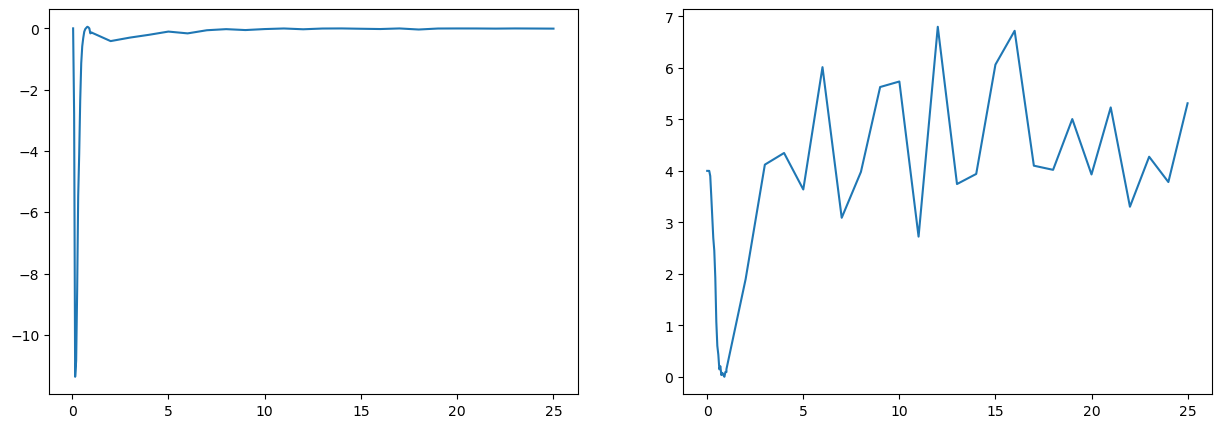

In [38]:
fig, axs = plt.subplots(1,2, figsize=(15,5))
axs[0].plot(temps.cpu(), grads_v1)
axs[1].plot(temps.cpu(), losses_v1)

## Num_steps = 100, 256x256 grid

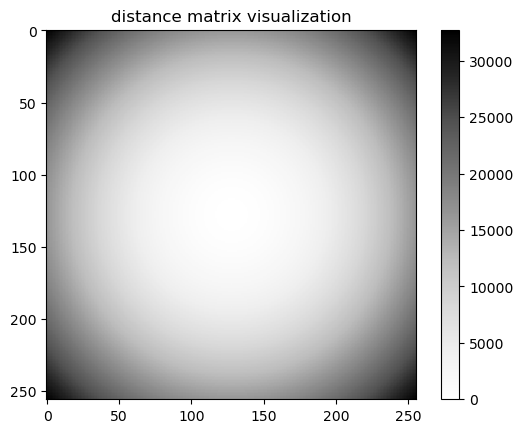

In [26]:
ref = t.zeros(1,256,256, device=device)
ref[:,128,128] += 1
dist_matrix = create_dist_matrix(ref)
fig = plt.imshow(dist_matrix.numpy(), cmap="Greys", interpolation="nearest", vmin=0, vmax=np.max(dist_matrix.numpy()))
plt.colorbar(fig)
plt.title("distance matrix visualization")
plt.show()

target_vol = 0, target_dist = 0

In [28]:
temps1 = t.linspace(0, 1, 20)
temps2 = t.linspace(1, 25, 25)
temps = t.concat((temps1, temps2))
target_vol = 0.
ref = t.zeros(1,256,256, device=device)
ref[:,128,128] += 1
dist_matrix = create_dist_matrix(ref)
target_distance = 0.

grads_v0 = []
mean_distances_v0 = []
losses_v0 = []
for temp in temps:
    temp.requires_grad_()
    batch = t.zeros(200,256,256, device=device)
    batch[:,128,128] += 1
    new_temp, grad, mean_distance, loss = step(batch, dist_matrix, temp, target_vol, eta=1, num_steps=100, target_distance=target_distance)
    grads_v0.append(grad.detach().cpu().numpy())
    mean_distances_v0.append(mean_distance.detach().cpu().numpy())
    losses_v0.append(loss.detach().cpu().numpy())

100%|██████████| 100/100 [00:05<00:00, 18.81it/s]


temperature: 0.0, mean distance: 0.0
gradient: nan


100%|██████████| 100/100 [00:04<00:00, 24.97it/s]


temperature: 0.05263157933950424, mean distance: 0.0
gradient: 0.0


100%|██████████| 100/100 [00:04<00:00, 24.77it/s]


temperature: 0.10526315867900848, mean distance: 0.0
gradient: 0.0


100%|██████████| 100/100 [00:04<00:00, 24.20it/s]


temperature: 0.15789473056793213, mean distance: 0.0
gradient: 0.0


100%|██████████| 100/100 [00:04<00:00, 24.58it/s]


temperature: 0.21052631735801697, mean distance: 0.0
gradient: 0.0


100%|██████████| 100/100 [00:03<00:00, 25.06it/s]


temperature: 0.2631579041481018, mean distance: 0.0
gradient: 0.0


100%|██████████| 100/100 [00:04<00:00, 24.14it/s]


temperature: 0.31578946113586426, mean distance: 0.0
gradient: 0.0


100%|██████████| 100/100 [00:04<00:00, 24.78it/s]


temperature: 0.3684210479259491, mean distance: 0.0
gradient: 0.0


100%|██████████| 100/100 [00:03<00:00, 25.09it/s]


temperature: 0.42105263471603394, mean distance: 0.0
gradient: 0.0


100%|██████████| 100/100 [00:03<00:00, 25.16it/s]


temperature: 0.4736842215061188, mean distance: 0.0
gradient: 0.0


100%|██████████| 100/100 [00:04<00:00, 24.98it/s]


temperature: 0.5263158082962036, mean distance: 0.0
gradient: 0.0


100%|██████████| 100/100 [00:03<00:00, 25.13it/s]


temperature: 0.5789473652839661, mean distance: 0.015000000000000003
gradient: 0.025223392993211746


100%|██████████| 100/100 [00:04<00:00, 24.77it/s]


temperature: 0.6315789222717285, mean distance: 0.02500000000000001
gradient: 0.04595676809549332


100%|██████████| 100/100 [00:03<00:00, 25.03it/s]


temperature: 0.6842105388641357, mean distance: 0.02
gradient: 0.046625375747680664


100%|██████████| 100/100 [00:03<00:00, 25.15it/s]


temperature: 0.7368420958518982, mean distance: 0.0325
gradient: 0.08380383253097534


100%|██████████| 100/100 [00:04<00:00, 24.97it/s]


temperature: 0.7894736528396606, mean distance: 0.0825
gradient: 0.21154651045799255


100%|██████████| 100/100 [00:03<00:00, 25.28it/s]


temperature: 0.8421052694320679, mean distance: 0.0575
gradient: 0.1487959921360016


100%|██████████| 100/100 [00:03<00:00, 25.00it/s]


temperature: 0.8947368264198303, mean distance: 0.105
gradient: 0.27195802330970764


100%|██████████| 100/100 [00:04<00:00, 24.80it/s]


temperature: 0.9473684430122375, mean distance: 0.1325
gradient: 0.3220212757587433


100%|██████████| 100/100 [00:04<00:00, 24.92it/s]


temperature: 1.0, mean distance: 0.1
gradient: 0.24871090054512024


100%|██████████| 100/100 [00:04<00:00, 24.07it/s]


temperature: 1.0, mean distance: 0.14250000000000004
gradient: 0.32327893376350403


100%|██████████| 100/100 [00:04<00:00, 24.75it/s]


temperature: 2.0, mean distance: 1.03
gradient: 0.4750519096851349


100%|██████████| 100/100 [00:04<00:00, 24.46it/s]


temperature: 3.0, mean distance: 1.905
gradient: 0.10405070334672928


100%|██████████| 100/100 [00:04<00:00, 24.02it/s]


temperature: 4.0, mean distance: 2.0525
gradient: 0.11869465559720993


100%|██████████| 100/100 [00:04<00:00, 23.78it/s]


temperature: 5.0, mean distance: 3.1875
gradient: -0.3974546492099762


100%|██████████| 100/100 [00:04<00:00, 23.65it/s]


temperature: 6.0, mean distance: 3.155
gradient: -0.28206557035446167


100%|██████████| 100/100 [00:04<00:00, 23.39it/s]


temperature: 7.0, mean distance: 3.0825
gradient: -0.19410404562950134


100%|██████████| 100/100 [00:04<00:00, 23.73it/s]


temperature: 8.0, mean distance: 3.675
gradient: -0.20429019629955292


100%|██████████| 100/100 [00:04<00:00, 23.58it/s]


temperature: 9.0, mean distance: 2.9175
gradient: -0.09568727016448975


100%|██████████| 100/100 [00:04<00:00, 23.23it/s]


temperature: 10.0, mean distance: 3.73
gradient: -0.16568952798843384


100%|██████████| 100/100 [00:04<00:00, 23.01it/s]


temperature: 11.0, mean distance: 4.09
gradient: -0.11202771216630936


100%|██████████| 100/100 [00:04<00:00, 23.17it/s]


temperature: 12.0, mean distance: 3.6775
gradient: -0.06936337053775787


100%|██████████| 100/100 [00:04<00:00, 22.78it/s]


temperature: 13.0, mean distance: 3.46
gradient: -0.052763618528842926


100%|██████████| 100/100 [00:04<00:00, 21.24it/s]


temperature: 14.0, mean distance: 3.7875
gradient: -0.036430198699235916


100%|██████████| 100/100 [00:04<00:00, 23.17it/s]


temperature: 15.0, mean distance: 3.9675
gradient: -0.12054558843374252


100%|██████████| 100/100 [00:04<00:00, 22.00it/s]


temperature: 16.0, mean distance: 3.8225
gradient: -0.08686143159866333


100%|██████████| 100/100 [00:04<00:00, 23.00it/s]


temperature: 17.0, mean distance: 4.68
gradient: -0.10136056691408157


100%|██████████| 100/100 [00:04<00:00, 22.87it/s]


temperature: 18.0, mean distance: 3.94
gradient: -0.07365807145833969


100%|██████████| 100/100 [00:04<00:00, 23.16it/s]


temperature: 19.0, mean distance: 3.87
gradient: -0.06525778770446777


100%|██████████| 100/100 [00:04<00:00, 23.17it/s]


temperature: 20.0, mean distance: 4.19
gradient: -0.05408588796854019


100%|██████████| 100/100 [00:04<00:00, 23.44it/s]


temperature: 21.0, mean distance: 3.845
gradient: -0.043785396963357925


100%|██████████| 100/100 [00:04<00:00, 21.33it/s]


temperature: 22.0, mean distance: 3.89
gradient: -0.049261175096035004


100%|██████████| 100/100 [00:04<00:00, 23.03it/s]


temperature: 23.0, mean distance: 3.875
gradient: -0.023012027144432068


100%|██████████| 100/100 [00:04<00:00, 23.39it/s]


temperature: 24.0, mean distance: 4.755
gradient: -0.08145062625408173


100%|██████████| 100/100 [00:04<00:00, 23.22it/s]


temperature: 25.0, mean distance: 4.615
gradient: -0.04030513018369675


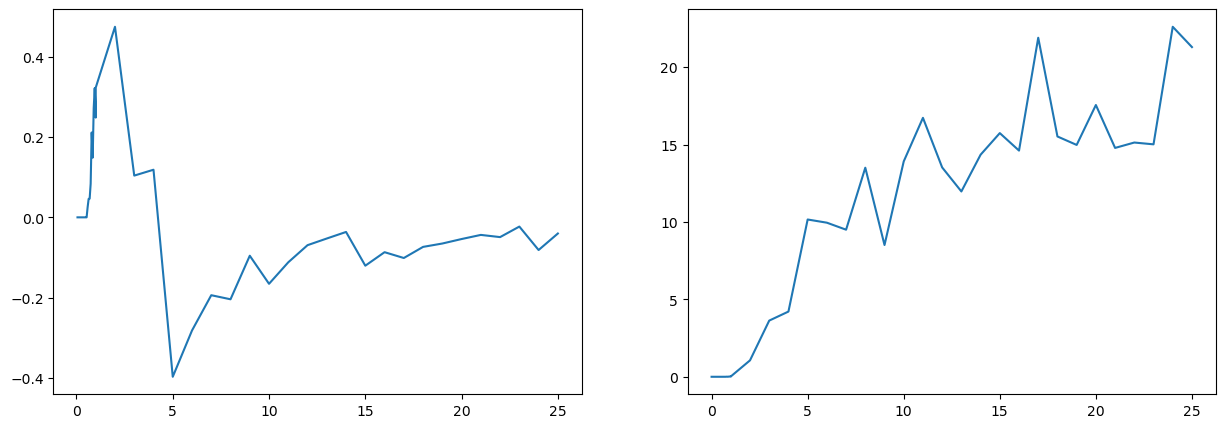

In [31]:
fig, axs = plt.subplots(1,2, figsize=(15,5))
axs[0].plot(temps.cpu(), grads_v0)
axs[1].plot(temps.cpu(), losses_v0)

target_vol = 1, target_dist = 0

In [ ]:
temps1 = t.linspace(0, 1, 20)
temps2 = t.linspace(1, 25, 25)
temps = t.concat((temps1, temps2))
target_vol = 1.
ref = t.zeros(1,256,256, device=device)
ref[:,128,128] += 1
dist_matrix = create_dist_matrix(ref)
target_distance = 0.

grads_v1 = []
mean_distances_v1 = []
losses_v1 = []
for temp in temps:
    temp.requires_grad_()
    batch = t.zeros(100,256,256, device=device)
    batch[:,128,128] += 1
    new_temp, grad, mean_distance, loss = step(batch, dist_matrix, temp, target_vol, eta=1, num_steps=500, target_distance=target_distance)
    grads_v1.append(grad.detach().cpu().numpy())
    mean_distances_v1.append(mean_distance.detach().cpu().numpy())
    losses_v1.append(loss.detach().cpu().numpy())